<a href="https://colab.research.google.com/github/asante69/Data-Analyst/blob/main/Sentiment_Analysis_and_Model_Testing_Technology.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Import your libraries for sentiment analysis

In [1]:
!pip install transformers
!pip install sentencepiece
!pip install nltk
!python -m nltk.downloader punkt
!pip install pandas
!pip install pyLDAvis
!pip install sklearn
!pip install gensim

<frozen runpy>:128: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [2]:
import numpy as np
import datetime as dt
import pandas as pd
import sklearn as sk
import sklearn.metrics as skm
import sklearn.cluster as skc
import sklearn.preprocessing as skp
import matplotlib.pyplot as plt
import altair as alt
import seaborn as sns
import string
import re
import nltk
from textblob import TextBlob
from wordcloud import WordCloud
import networkx as nx

import gensim
from gensim.utils import simple_preprocess
import scipy as sp
import scipy.spatial.distance as spd
import scipy.cluster.hierarchy as sph
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


##Load your scrapped Data

In [3]:
df = pd.read_csv('Technology.csv')

# Print some info about the concatenated dataframe (optional)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4302 entries, 0 to 4301
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Comment  4302 non-null   object
dtypes: object(1)
memory usage: 33.7+ KB
None


In [4]:
df.head()

,Comment
0,Santa's good list.
1,Tiktok Oracle deal coming soon.
2,wtf? There goes my house!!!
3,this needs to rally. Finger over the sell button
4,gotta invest in the oligarch stocks theyâ€™ll ...


In [6]:
df.duplicated().sum()

0

In [ ]:
#df = pd.read_csv("/content/Manufacturing.csv")
#df.head()

##Load Stopwords

In [8]:
# Load stop words
stop_words = stopwords.words('english')

# Show stop words
stop_words[:10]

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an']

##Perform data cleaning by removing hastags, urls, mentions, symbols, www, pictures, emoji, etc

In [9]:

# Removing hashtags and mentions
def get_hashtags(text):
    hashtags = re.findall(r'\#\w+',text.lower())
    return hashtags
def get_mentions(text):
    mentions = re.findall(r'\@\w+',text.lower())
    return mentions

# Cleaning up the text of the tweets
def remove_content(text):
    text = re.sub(r"http\S+", "", text) #remove urls
    text=re.sub(r'\S+\.com\S+','',text) #remove urls
    text=re.sub(r'\@\w+','',text) #remove mentions
    text =re.sub(r'\#\w+','',text) #remove hashtags
    return text

def process_tweet(tweet):
    """
    tweets cleaning by
    1) lowering the case of the tweet,
    2) removing unwanted symbols and replacing them with a whitespace,
    3) split sentences into words according to whitespaces and then
    4) join back with a single whitespace as separator between various words
    """
    return " ".join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])", " ",tweet.lower()).split())

def process_text(text, stem=False): #clean text
    text=remove_content(text)
    lemmatizer=WordNetLemmatizer()
    text = re.sub('[^A-Za-z]', ' ', text.lower()) #remove non-alphabets
    text = re.sub(r'@[A-Za-z0-9]+', '', str(text)) # remove @mentions
    text = re.sub(r'#', '',  str(text)) # remove the '#' symbol
    text = re.sub(r'RT[\s]+', '',  str(text)) # remove RT
    text = re.sub(r'https?\/\/S+', '',  str(text)) # remove the hyperlink
    text = re.sub(r'http\S+', '',  str(text)) # remove the hyperlink
    text = re.sub(r'www\S+', '',  str(text)) # remove the www
    text = re.sub(r'pic+', '',  str(text)) # remove the pic
    text = re.sub(r'com', '',  str(text)) # remove the pic
    text = re.sub(r"\bamp\b", ' ', text.lower()) #remove "amp" which is coming from the translation of &
    text = re.sub(r"\bco\b", ' ', text.lower()) #remove "co" which was one of the top words found below
    tokenized_text = word_tokenize(text) #tokenize
    #tokenized_text = [lemmatizer.lemmatize(word) for word in tokenized_text]
    clean_text = [
         word for word in tokenized_text
         if (word not in stop_words and len(word)>1)
    ]
    if stem:
        clean_text=[stemmer.stem(word) for word in clean_text]
    clean_text = [lemmatizer.lemmatize(word) for word in clean_text]
    return ' '.join(clean_text)

#functions used to remove search terms from all the tweets
#function to remove duplicates from a string - in this case the string is the keywords used to scrape the tweets
def removeDupWithoutOrder(string):
    words = string.lower().split()
    return " ".join(sorted(set(words), key=words.index)).replace('OR', '').replace('  ', ' ')

#function to search for string i.e. remove specific words (search_terms in this case)
def remove_search(text, search_terms):
    query = text.lower()
    querywords = query.split()
    resultwords  = [word for word in querywords if word.lower() not in search_terms]
    return ' '.join(resultwords)

# define function to plot frequency of bi-grams, tri-grams, single words, phrases etc
from sklearn.feature_extraction.text import CountVectorizer
def plot_topn(sentences, ngram_range=(1,3), top=20,firstword=''):
    c=CountVectorizer(ngram_range=ngram_range)
    X=c.fit_transform(sentences)
    words=pd.DataFrame(X.sum(axis=0),columns=c.get_feature_names()).T.sort_values(0,ascending=False).reset_index()
    res=words[words['index'].apply(lambda x: firstword in x)].head(top)
    pl=px.bar(res, x='index',y=0)
    pl.update_layout(yaxis_title='count',xaxis_title='Phrases')

In [10]:
import re
re.compile('<title>(.*)</title>')

re.compile(r'<title>(.*)</title>', re.UNICODE)

In [11]:
# removing useless content (hashtags, mentions)
df['Comment'].apply(str)

,Comment
0,Santa's good list.
1,Tiktok Oracle deal coming soon.
2,wtf? There goes my house!!!
3,this needs to rally. Finger over the sell button
4,gotta invest in the oligarch stocks theyâ€™ll ...
...,...
4297,Today - Services PMI @ 9.45am. Bulls in Contro...
4298,whole market ripping and this is dumpingâ€¦ ty...
4299,Buy levels live chart
4300,$270 SOLD


In [12]:
df['cleaned_comments'] = df['Comment'].astype(str).apply(lambda x: process_tweet(x))

In [13]:
df

,Comment,cleaned_comments
0,Santa's good list.,santa s good list
1,Tiktok Oracle deal coming soon.,tiktok oracle deal coming soon
2,wtf? There goes my house!!!,wtf there goes my house
3,this needs to rally. Finger over the sell button,this needs to rally finger over the sell button
4,gotta invest in the oligarch stocks theyâ€™ll ...,gotta invest in the oligarch stocks they ll al...
...,...,...
4297,Today - Services PMI @ 9.45am. Bulls in Contro...,today services pmi 9 45am bulls in control abo...
4298,whole market ripping and this is dumpingâ€¦ ty...,whole market ripping and this is dumping typic...
4299,Buy levels live chart,buy levels live chart
4300,$270 SOLD,270 sold


###Check the number of comments or reviews in the dataset

In [14]:
df['cleaned_comments'].nunique()

4233

In [15]:
#Save cleaned_comments data
df.to_csv('cleaned_comments.csv', index=False)

In [16]:
df['Comment'] = df['Comment'].str.replace('http\S+', '')


###Generate Word Frequency to analyze the most occuring word within the dataset

In [17]:
from PIL import Image
import urllib
import requests
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

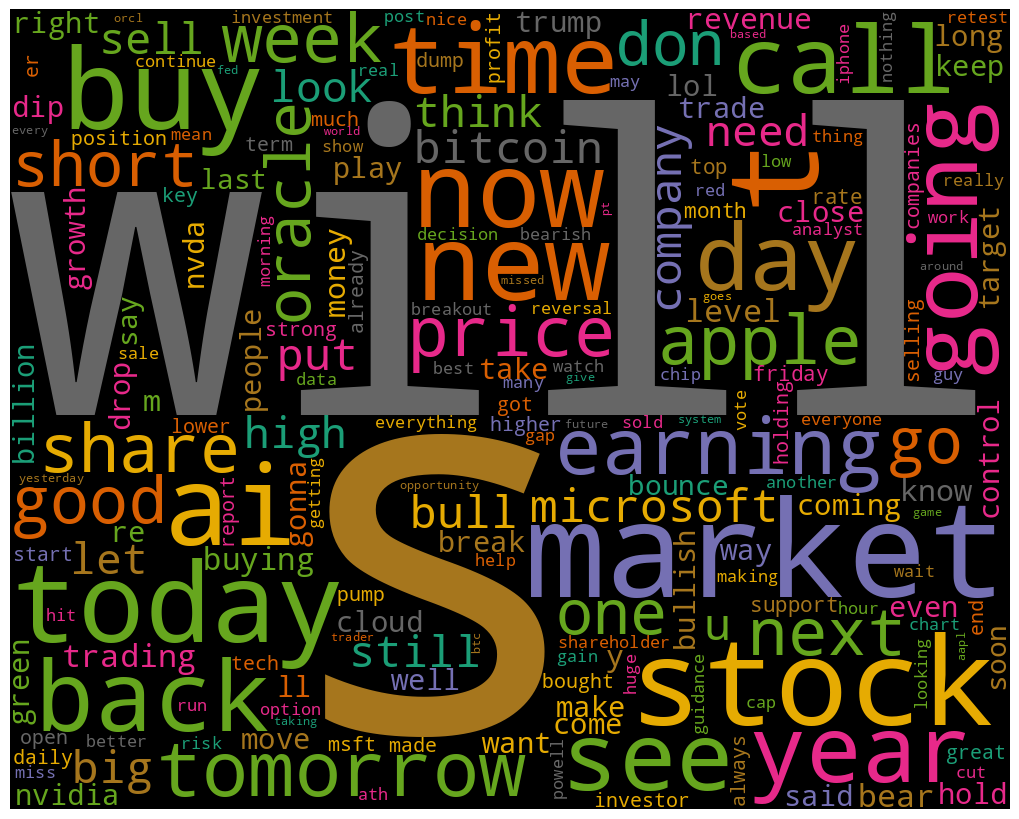

In [18]:
comment_words = ''
stopwords = set(STOPWORDS)

# iterate through the csv file
for val in df.cleaned_comments:

    # typecaste each val to string
    val = str(val)

    # split the value
    tokens = val.split()

    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()

    comment_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 1000, height = 800,
                background_color='black', colormap='Dark2',
                collocations=False,
                stopwords = stopwords,
                min_font_size = 12).generate(comment_words)

# plot the WordCloud image
plt.figure(figsize = (10, 10), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

###Plot Polarity and Subjectivity Scores

In [19]:
def getSubjectivity(text):
    return TextBlob( str(text)).sentiment.subjectivity

def getPolarity(text):
    return TextBlob( str(text)).sentiment.polarity

In [20]:
df.dropna(subset=['cleaned_comments'], inplace = True)
df.reset_index(drop=True, inplace=True)

In [21]:
df['Subjectivity'] = df['cleaned_comments'].apply(getSubjectivity)
df['Polarity'] = df['cleaned_comments'].apply(getPolarity)
df.head()

,Comment,cleaned_comments,Subjectivity,Polarity
0,Santa's good list.,santa s good list,0.600000,0.700000
1,Tiktok Oracle deal coming soon.,tiktok oracle deal coming soon,0.000000,0.000000
2,wtf? There goes my house!!!,wtf there goes my house,1.000000,-0.500000
3,this needs to rally. Finger over the sell button,this needs to rally finger over the sell button,0.000000,0.000000
4,gotta invest in the oligarch stocks theyâ€™ll ...,gotta invest in the oligarch stocks they ll al...,0.283333,0.033333


In [22]:

def get_Polarity_Analysis(score):
    if score < 0:
      return 'Negative'
    elif score == 0:
      return 'Neutral'
    else:
      return 'Positive'
def get_Subjectivity_Analysis(score):
    if score >  0:
      return 'Opinion'
    else:
      return 'Fact'

df['Analysis_Polarity'] = df['Polarity'].apply(get_Polarity_Analysis)

df['Analysis_Subjectivity'] = df['Subjectivity'].apply(get_Subjectivity_Analysis)

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(font_scale=2)

###Plot Polarity and Subjectiviy Score in Scatter Plot

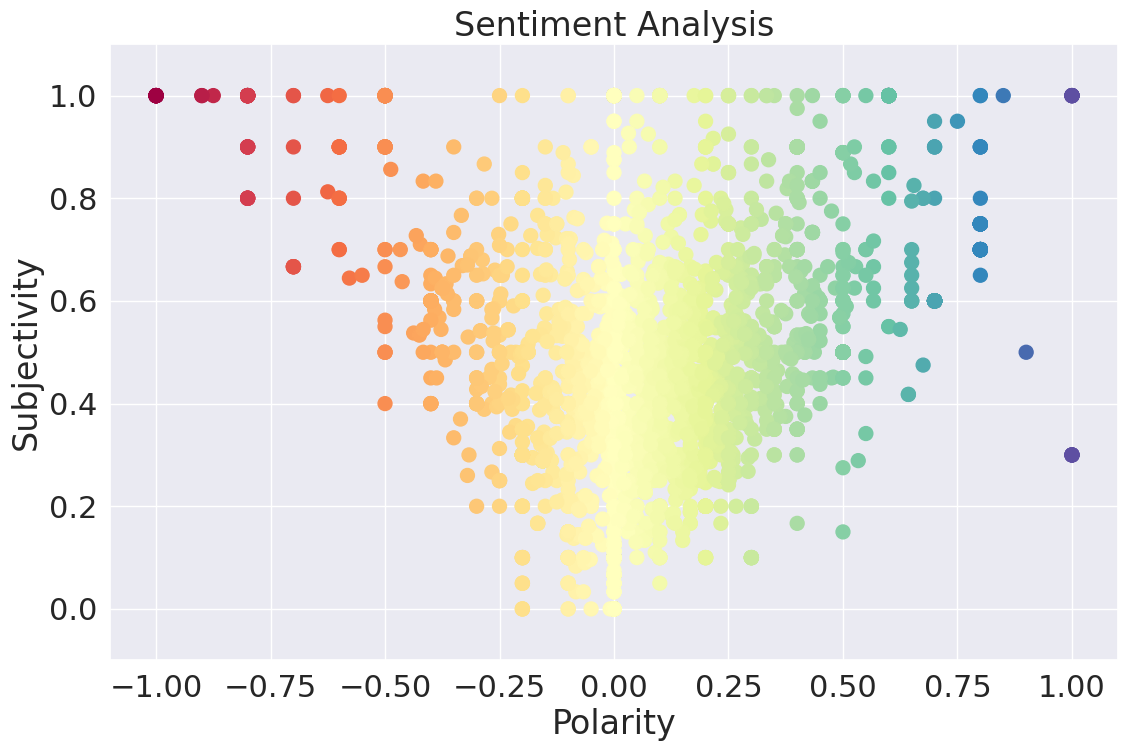

(None,)

In [24]:
plt.figure(figsize=(13,8))

plt.scatter(df['Polarity'], df['Subjectivity'], c=df['Polarity'], s=100, cmap='Spectral')

plt.xlim(-1.1, 1.1)
plt.ylim(-0.1, 1.1)
plt.title('Sentiment Analysis')
plt.xlabel('Polarity')
plt.ylabel('Subjectivity')
plt.show(),

In [25]:
df['Sentiment'] = df.apply(lambda x: ' '.join([str(x['Analysis_Polarity']),str(x['Analysis_Subjectivity'])]),axis=1)
df.head()


,Comment,cleaned_comments,Subjectivity,Polarity,Analysis_Polarity,Analysis_Subjectivity,Sentiment
0,Santa's good list.,santa s good list,0.600000,0.700000,Positive,Opinion,Positive Opinion
1,Tiktok Oracle deal coming soon.,tiktok oracle deal coming soon,0.000000,0.000000,Neutral,Fact,Neutral Fact
2,wtf? There goes my house!!!,wtf there goes my house,1.000000,-0.500000,Negative,Opinion,Negative Opinion
3,this needs to rally. Finger over the sell button,this needs to rally finger over the sell button,0.000000,0.000000,Neutral,Fact,Neutral Fact
4,gotta invest in the oligarch stocks theyâ€™ll ...,gotta invest in the oligarch stocks they ll al...,0.283333,0.033333,Positive,Opinion,Positive Opinion


###Plot Polarity Score for the entire dataset using bar chart

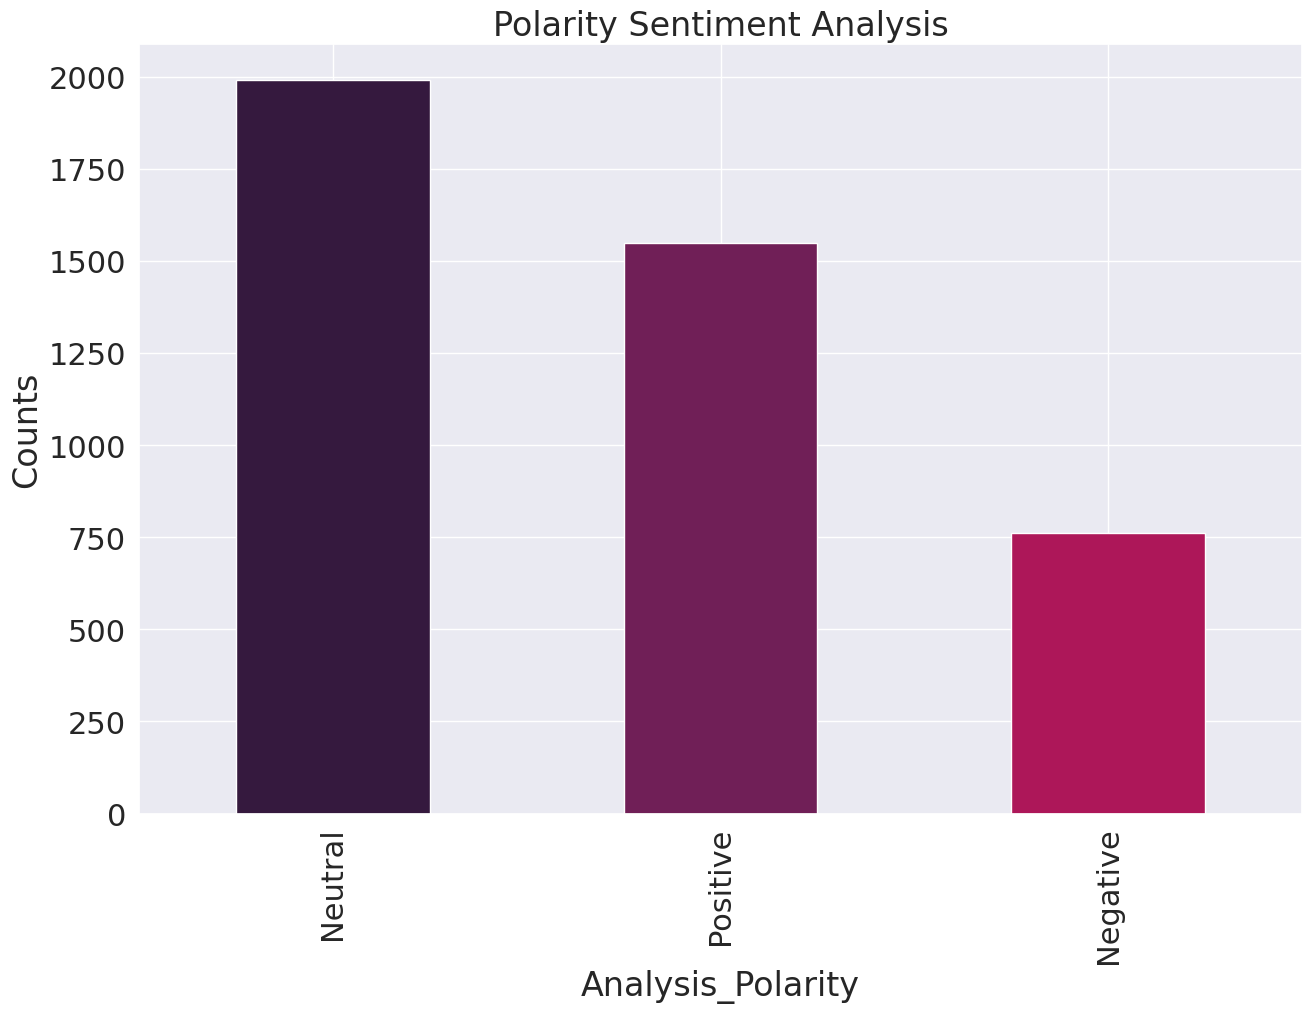

In [26]:

plt.figure(figsize=(15,10))

plt.title('Polarity Sentiment Analysis')
plt.xlabel('Sentiment')
plt.ylabel('Counts')
df['Analysis_Polarity'].value_counts().plot(kind = 'bar',  color=sns.palettes.mpl_palette('rocket'))
plt.show()

###Plot Subjectivity and Objective

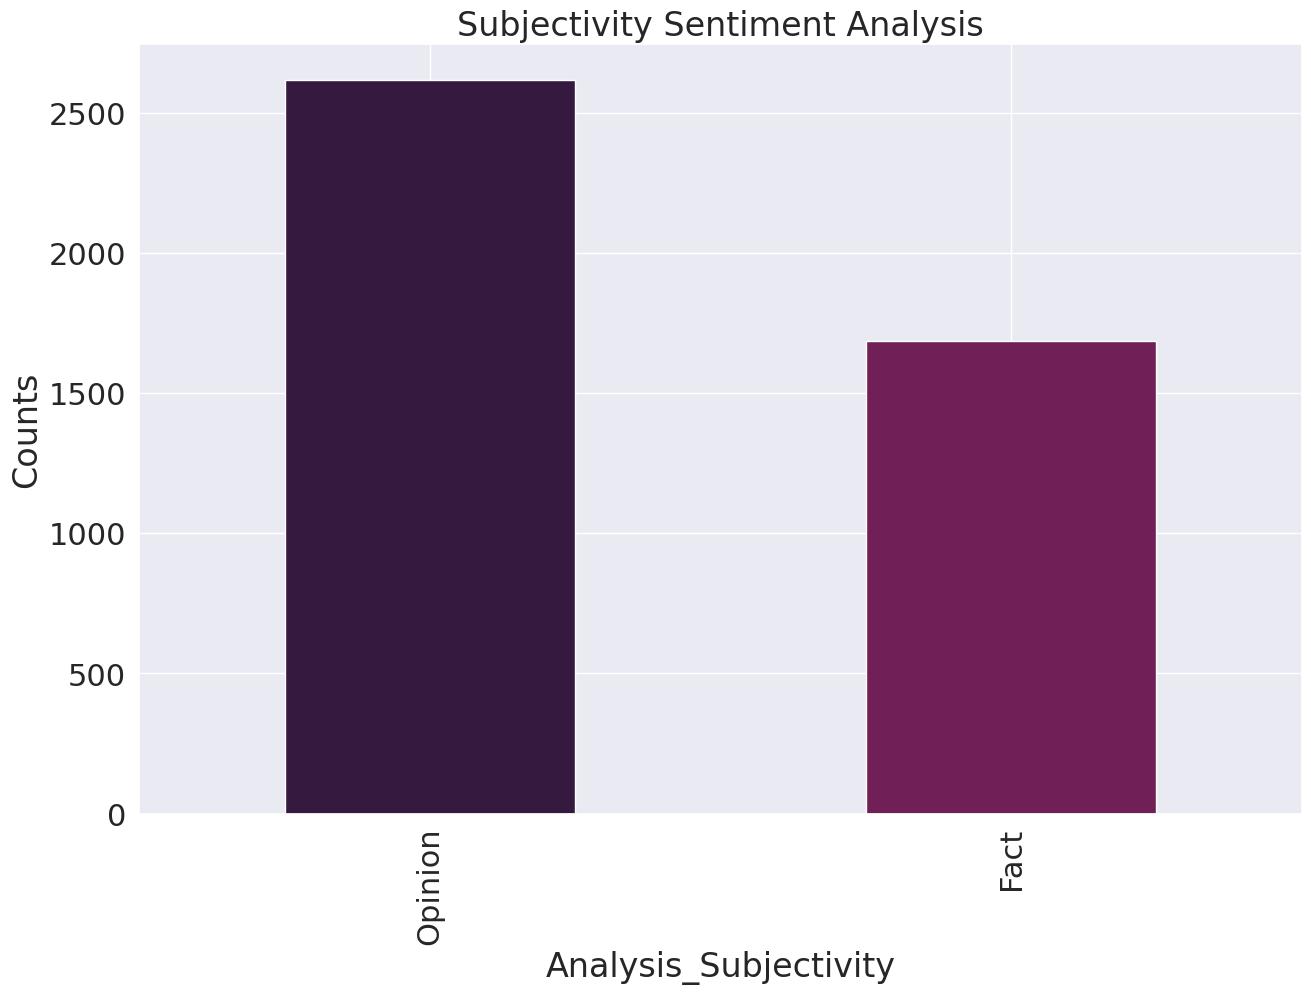

In [27]:
plt.figure(figsize=(15,10))
plt.title('Subjectivity Sentiment Analysis')
plt.xlabel('Sentiment')
plt.ylabel('Counts')
df['Analysis_Subjectivity'].value_counts().plot(kind = 'bar',  color=sns.palettes.mpl_palette('rocket'))
plt.show()


In [28]:
import pyLDAvis
import pyLDAvis.gensim
import pickle
import os

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [29]:
!pip install gensim

In [30]:

pyLDAvis.enable_notebook()


In [31]:
tf_vectorizer = CountVectorizer(strip_accents = 'unicode',
                                stop_words = 'english',
                                lowercase = True,
                                token_pattern = r'\b[a-zA-Z]{3,}\b',
                                max_df = 0.5,
                                min_df = 10)
dtm_tf = tf_vectorizer.fit_transform(df['cleaned_comments'].values.astype('U'))
print(dtm_tf.shape)

(4302, 733)


In [32]:
tfidf_vectorizer = TfidfVectorizer(**tf_vectorizer.get_params())
dtm_tfidf = tfidf_vectorizer.fit_transform(df['cleaned_comments'].values.astype('U'))
print(dtm_tfidf.shape)

(4302, 733)


In [33]:
# for TF DTM
lda_tf = LatentDirichletAllocation(n_components =10, random_state=50)
lda_tf.fit(dtm_tf)
# for TFIDF DTM
lda_tfidf = LatentDirichletAllocation(n_components =10, random_state=50)
lda_tfidf.fit(dtm_tfidf)

LatentDirichletAllocation(random_state=50)

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [35]:
import pyLDAvis.lda_model
...
pyLDAvis.lda_model.prepare

<function pyLDAvis.lda_model.prepare(lda_model, dtm, vectorizer, **kwargs)>

In [46]:
nltk.download('stopwords')
from nltk.corpus import stopwords  # Import the stopwords module

english_stopwords = stopwords.words('english')  # Call words on the module
english_stopwords.extend(['from', 'subject', 're', 'edu', 'use'])

def sentences_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuation.
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in english_stopwords] for doc in texts]

comments = df.cleaned_comments.to_list()
comment_words = list(sentences_to_words(comments))

# Remove stop words.
comment_words = remove_stopwords(comment_words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [47]:
import gensim.corpora as corpora

# Create Dictionary.
id2word = corpora.Dictionary(comment_words)

# Create Corpus.
texts = comment_words

# Term Document Frequency.
corpus = [id2word.doc2bow(text) for text in texts]

In [48]:
from pprint import pprint

# Number of topics.
num_topics = 10

# Build LDA model.
lda_model = gensim.models.LdaMulticore(
    corpus=corpus,
    id2word=id2word,
    num_topics=num_topics
)

# Print the Keyword in the 10 topics.
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.010*"new" + 0.009*"price" + 0.007*"buy" + 0.007*"money" + 0.007*"stock" + '
  '0.007*"market" + 0.006*"one" + 0.006*"back" + 0.006*"week" + 0.005*"made"'),
 (1,
  '0.014*"market" + 0.012*"would" + 0.009*"apple" + 0.007*"cap" + 0.007*"new" '
  '+ 0.006*"tomorrow" + 0.006*"see" + 0.005*"today" + 0.005*"take" + '
  '0.005*"world"'),
 (2,
  '0.016*"apple" + 0.010*"ai" + 0.010*"like" + 0.007*"news" + 0.006*"price" + '
  '0.006*"go" + 0.006*"bounce" + 0.006*"market" + 0.006*"think" + '
  '0.006*"decline"'),
 (3,
  '0.015*"apple" + 0.010*"going" + 0.009*"new" + 0.008*"market" + '
  '0.007*"china" + 0.007*"week" + 0.007*"stock" + 0.007*"company" + '
  '0.006*"time" + 0.006*"still"'),
 (4,
  '0.025*"control" + 0.014*"bears" + 0.013*"bulls" + 0.013*"break" + '
  '0.013*"reversal" + 0.013*"play" + 0.013*"breakdown" + 0.013*"breakout" + '
  '0.013*"reclaim" + 0.013*"retest"'),
 (5,
  '0.012*"ai" + 0.012*"week" + 0.009*"get" + 0.008*"see" + 0.008*"next" + '
  '0.007*"going" + 0.007*"like"

In [50]:
import pyLDAvis
import pyLDAvis.gensim
import pickle
import os

# Visualize the topics.
pyLDAvis.enable_notebook()

LDAvis_data_filepath = os.path.join(f'cleaned_comments_lda_{num_topics}.data')

if os.path.exists(LDAvis_data_filepath):
    # Load the pre-prepared pyLDAvis data from disk.
    with open(LDAvis_data_filepath, 'rb') as f:
        LDAvis_prepared = pickle.load(f)
else:
    LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)

pyLDAvis.save_html(LDAvis_prepared, f'{LDAvis_data_filepath}.html')

In [51]:
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9      0.031996 -0.006498       1        1  14.495397
4      0.026327  0.040697       2        1  11.595405
3      0.085349  0.012976       3        1  10.613243
0     -0.109570 -0.017232       4        1  10.383825
5     -0.078444 -0.061900       5        1  10.036664
2     -0.052402 -0.088469       6        1   9.670593
6     -0.066323  0.144076       7        1   9.450772
1      0.091295 -0.076650       8        1   8.857014
8      0.058874  0.054788       9        1   7.860588
7      0.012897 -0.001788      10        1   7.036499, topic_info=           Term        Freq       Total Category  logprob  loglift
2195    control  163.000000  163.000000  Default  30.0000  30.0000
214         buy  214.000000  214.000000  Default  29.0000  29.0000
1781   reversal  102.000000  102.000000  Default  28.0000  28.0000
432         one  161.000000  161.000000  Default  27.0000  27.0000
696   breakdown   78.000000   78.000000  Default  26.0000  26.0000
...         ...         ...         ...      ...      ...      ...
687       lower    9.919489   55.600054  Topic10  -5.7189   0.9304
426        next   11.083699  172.523881  Topic10  -5.6080  -0.0910
33        right   10.383278   90.226303  Topic10  -5.6732   0.4919
244        like   11.359351  255.441876  Topic10  -5.5834  -0.4589
1083      apple   11.383991  329.868562  Topic10  -5.5812  -0.7124

[710 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
3175      1  0.107787  aapl
3175      2  0.138583  aapl
3175      3  0.107787  aapl
3175      4  0.015398  aapl
3175      5  0.107787  aapl
...     ...       ...   ...
2093      2  0.045896  zone
2093      5  0.688434  zone
2093      6  0.137687  zone
2093      7  0.045896  zone
2093     10  0.045896  zone

[2141 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 5, 4, 1, 6, 3, 7, 2, 9, 8])

In [52]:
topic_values = lda_tf.transform(dtm_tf)
topic_values.shape

(4302, 10)

In [53]:
df.head()

,Comment,cleaned_comments,Subjectivity,Polarity,Analysis_Polarity,Analysis_Subjectivity,Sentiment,Topic
0,Santa's good list.,santa s good list,0.600000,0.700000,Positive,Opinion,Positive Opinion,3
1,Tiktok Oracle deal coming soon.,tiktok oracle deal coming soon,0.000000,0.000000,Neutral,Fact,Neutral Fact,0
2,wtf? There goes my house!!!,wtf there goes my house,1.000000,-0.500000,Negative,Opinion,Negative Opinion,7
3,this needs to rally. Finger over the sell button,this needs to rally finger over the sell button,0.000000,0.000000,Neutral,Fact,Neutral Fact,4
4,gotta invest in the oligarch stocks theyâ€™ll ...,gotta invest in the oligarch stocks they ll al...,0.283333,0.033333,Positive,Opinion,Positive Opinion,3


In [54]:
df_1=df.replace({0:'Stock Market Trends',1:'Technical Analysis & Trading Signals',2:'Stock Performance & Predictions',3:'Stock Breakouts',4:'Investment Opportunities & Risks',5:'Market News Impact',6:'AI & Technology',7:'Buying & Selling Strategies',8:'Market Innovation',9:'Stock Valuation & Investment Behavior'})

In [55]:
#df_1['topic'] = topic_values.argmax(axis=1)

In [56]:
df['Topic'] = topic_values.argmax(axis=1)

In [57]:
df_1.head()

,Comment,cleaned_comments,Subjectivity,Polarity,Analysis_Polarity,Analysis_Subjectivity,Sentiment,Topic
0,Santa's good list.,santa s good list,0.6,0.7,Positive,Opinion,Positive Opinion,Stock Breakouts
1,Tiktok Oracle deal coming soon.,tiktok oracle deal coming soon,Stock Market Trends,Stock Market Trends,Neutral,Fact,Neutral Fact,Stock Market Trends
2,wtf? There goes my house!!!,wtf there goes my house,Technical Analysis & Trading Signals,-0.5,Negative,Opinion,Negative Opinion,Buying & Selling Strategies
3,this needs to rally. Finger over the sell button,this needs to rally finger over the sell button,Stock Market Trends,Stock Market Trends,Neutral,Fact,Neutral Fact,Investment Opportunities & Risks
4,gotta invest in the oligarch stocks theyâ€™ll ...,gotta invest in the oligarch stocks they ll al...,0.283333,0.033333,Positive,Opinion,Positive Opinion,Stock Breakouts


In [58]:
df_1.columns

Index(['Comment', 'cleaned_comments', 'Subjectivity', 'Polarity',
       'Analysis_Polarity', 'Analysis_Subjectivity', 'Sentiment', 'Topic'],
      dtype='object')

<Figure size 4000x2500 with 0 Axes>

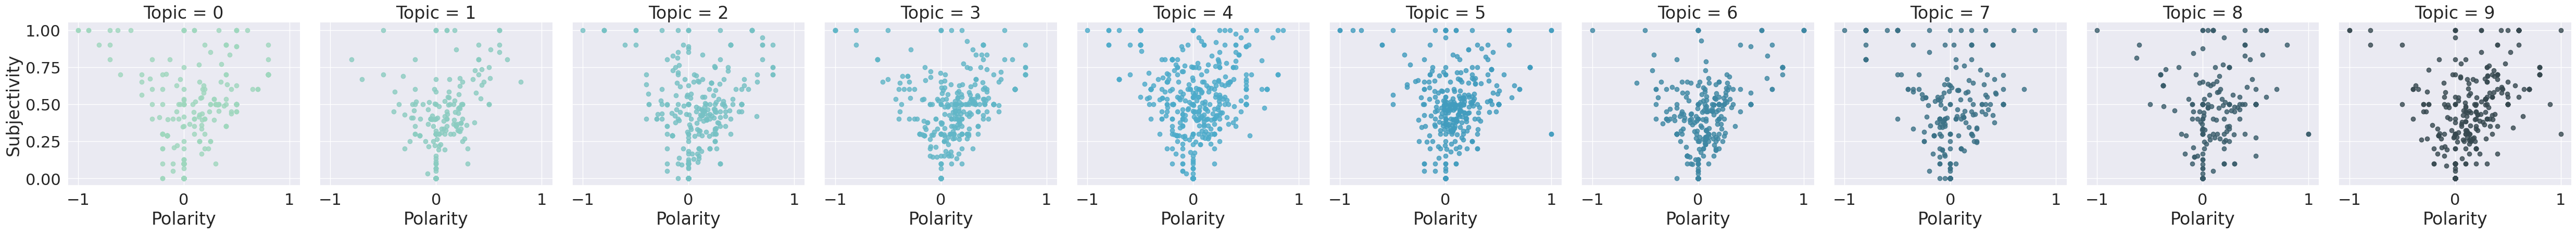

In [59]:
plt.figure(figsize=(40,25))

g=sns.lmplot(x="Polarity", y="Subjectivity", hue='Topic', data=df, fit_reg=False, legend=False,palette="GnBu_d", col='Topic', legend_out=True)


plt.show()

In [60]:
df_2 = df_1.groupby(['Topic'])['Analysis_Polarity'].value_counts().unstack('Topic').transpose()

df_2

Analysis_Polarity,Negative,Neutral,Positive
Topic,,,
AI & Technology,84,177,177
Buying & Selling Strategies,93,140,83
Investment Opportunities & Risks,165,226,204
Market Innovation,37,143,107
Market News Impact,82,93,201
Stock Breakouts,70,132,223
Stock Market Trends,57,536,114
Stock Performance & Predictions,70,216,161
Stock Valuation & Investment Behavior,54,182,185


In [61]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10 entries, AI & Technology to Technical Analysis & Trading Signals
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   Negative  10 non-null     int64
 1   Neutral   10 non-null     int64
 2   Positive  10 non-null     int64
dtypes: int64(3)
memory usage: 320.0+ bytes


In [62]:
df_2['Total'] = df_2.sum(axis=1)

In [ ]:
df_2.columns

In [63]:
for i in df_2:
    df_2[i] = round(df_2[i]*100/df_2.Total)

df_2

Analysis_Polarity,Negative,Neutral,Positive,Total
Topic,,,,
AI & Technology,19.0,40.0,40.0,100.0
Buying & Selling Strategies,29.0,44.0,26.0,100.0
Investment Opportunities & Risks,28.0,38.0,34.0,100.0
Market Innovation,13.0,50.0,37.0,100.0
Market News Impact,22.0,25.0,53.0,100.0
Stock Breakouts,16.0,31.0,52.0,100.0
Stock Market Trends,8.0,76.0,16.0,100.0
Stock Performance & Predictions,16.0,48.0,36.0,100.0
Stock Valuation & Investment Behavior,13.0,43.0,44.0,100.0


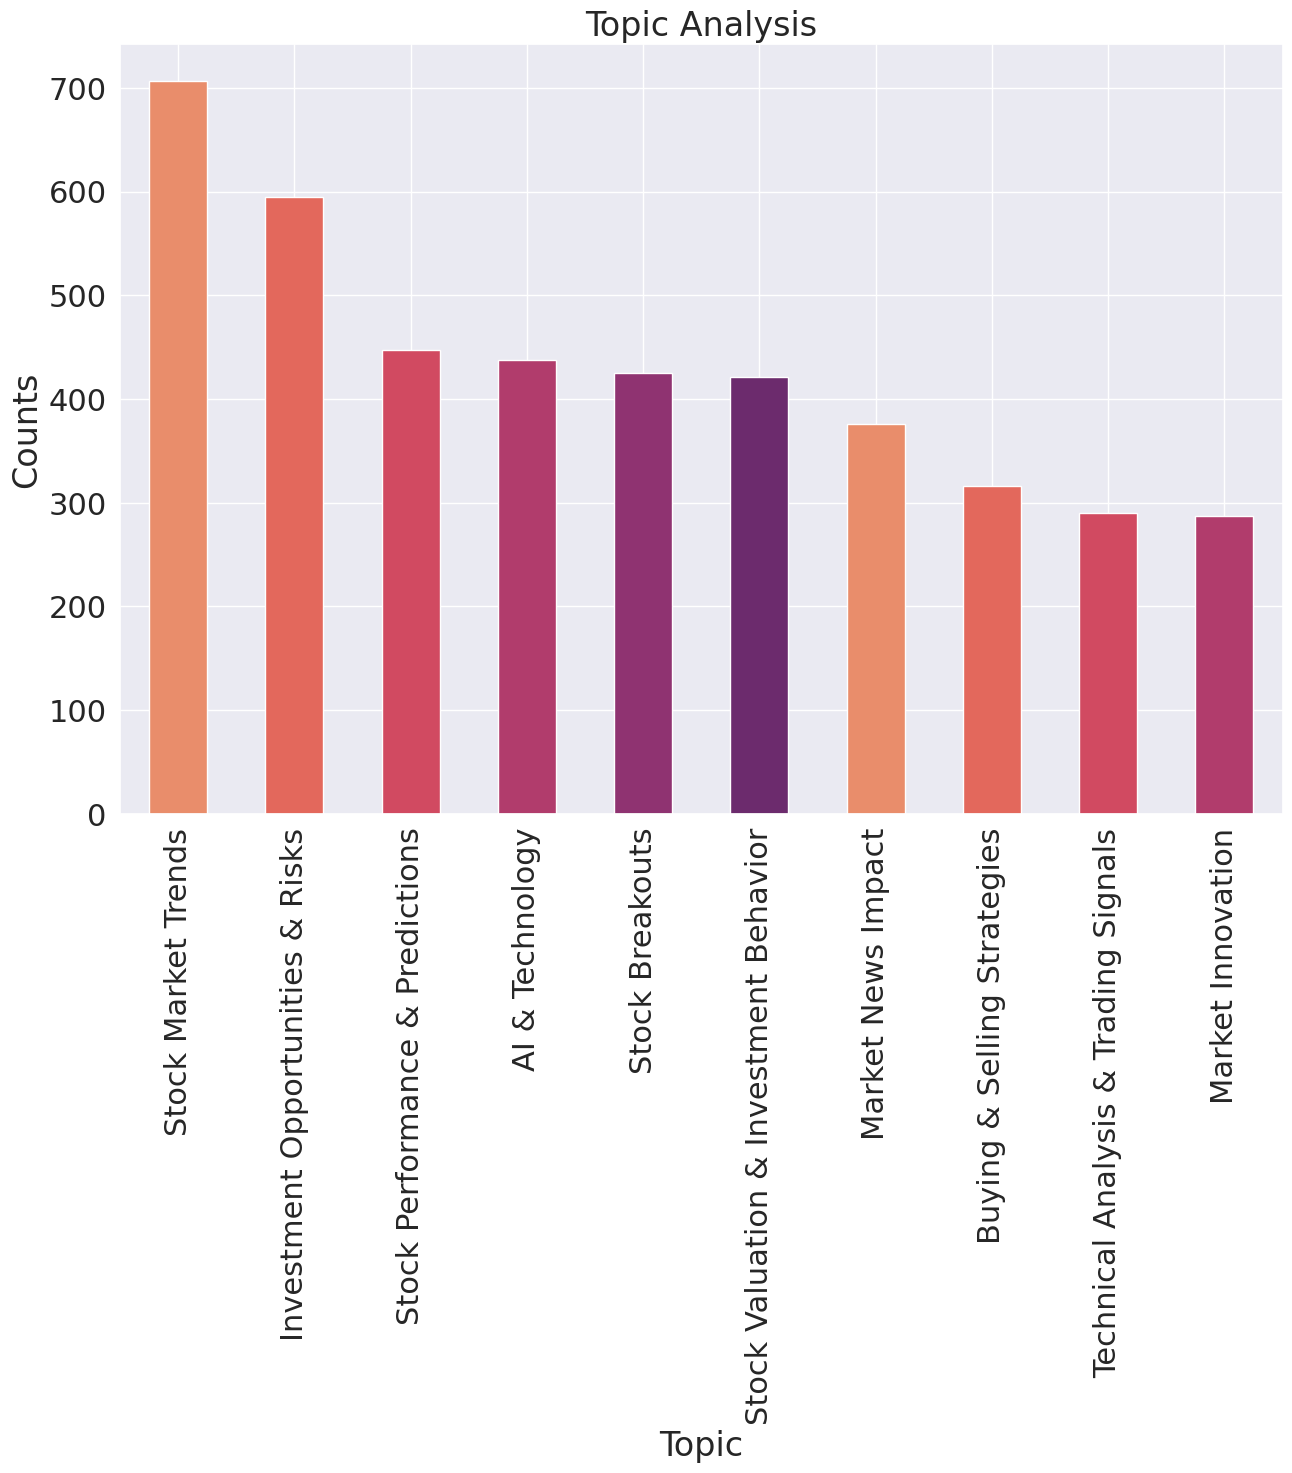

In [64]:
# Plot and visualizing the counts for each topic
plt.figure(figsize=(15,10))

plt.title('Topic Analysis')
plt.xlabel('Topic')
plt.ylabel('Counts')
df_1['Topic'].value_counts().plot(kind = 'bar',  color=sns.palettes.mpl_palette('flare'))
plt.show()


In [65]:
df_2=df_2.fillna(0)

In [66]:
df_2['Total'] = df_2.sum(axis=1)
df_2 = df_2.drop(['Total'], axis=1)

In [67]:
print(df_2.shape)

(10, 3)


In [68]:
print(df_2.head())

Analysis_Polarity                 Negative  Neutral  Positive
Topic                                                        
AI & Technology                       19.0     40.0      40.0
Buying & Selling Strategies           29.0     44.0      26.0
Investment Opportunities & Risks      28.0     38.0      34.0
Market Innovation                     13.0     50.0      37.0
Market News Impact                    22.0     25.0      53.0


In [69]:
print(df_2.tail())

Analysis_Polarity                      Negative  Neutral  Positive
Topic                                                             
Stock Breakouts                            16.0     31.0      52.0
Stock Market Trends                         8.0     76.0      16.0
Stock Performance & Predictions            16.0     48.0      36.0
Stock Valuation & Investment Behavior      13.0     43.0      44.0
Technical Analysis & Trading Signals       17.0     50.0      32.0


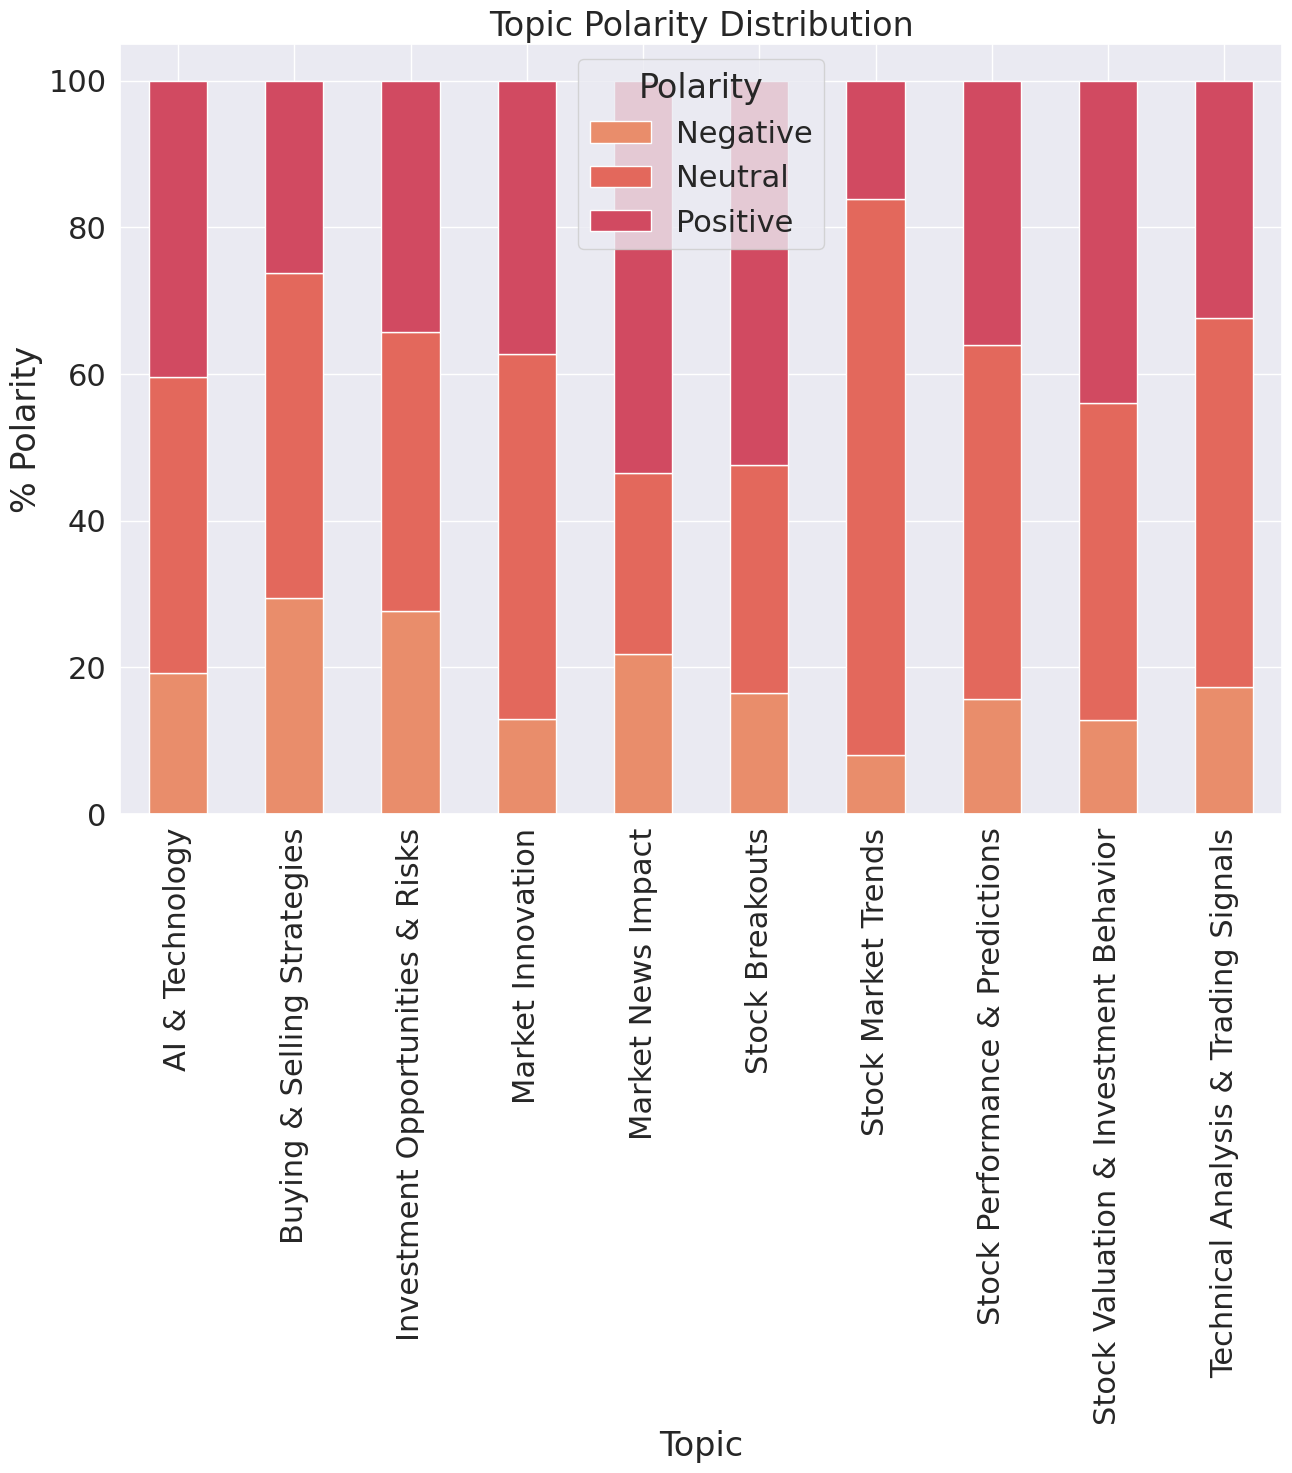

In [70]:
# Create a new dataframe with topic names and polarity percentages
df_topic_polarity = df_1.groupby('Topic')['Analysis_Polarity'].value_counts().unstack(fill_value=0).apply(lambda x: x / x.sum() * 100, axis=1)

# Create the stacked bar plot
ax = df_topic_polarity.plot(kind='bar',color=sns.palettes.mpl_palette('flare'), stacked=True, figsize=(15, 10))

# Add labels and title
ax.set_xlabel('Topic')
ax.set_ylabel('% Polarity')
ax.set_title('Topic Polarity Distribution')

# Add topic names to the x-axis
ax.set_xticklabels(df_topic_polarity.index, rotation=90)

# Add legend
ax.legend(title='Polarity')

# Show the plot
plt.show()


###Perform Topic Labeling to analyze the polarity score of each of the topics identified.

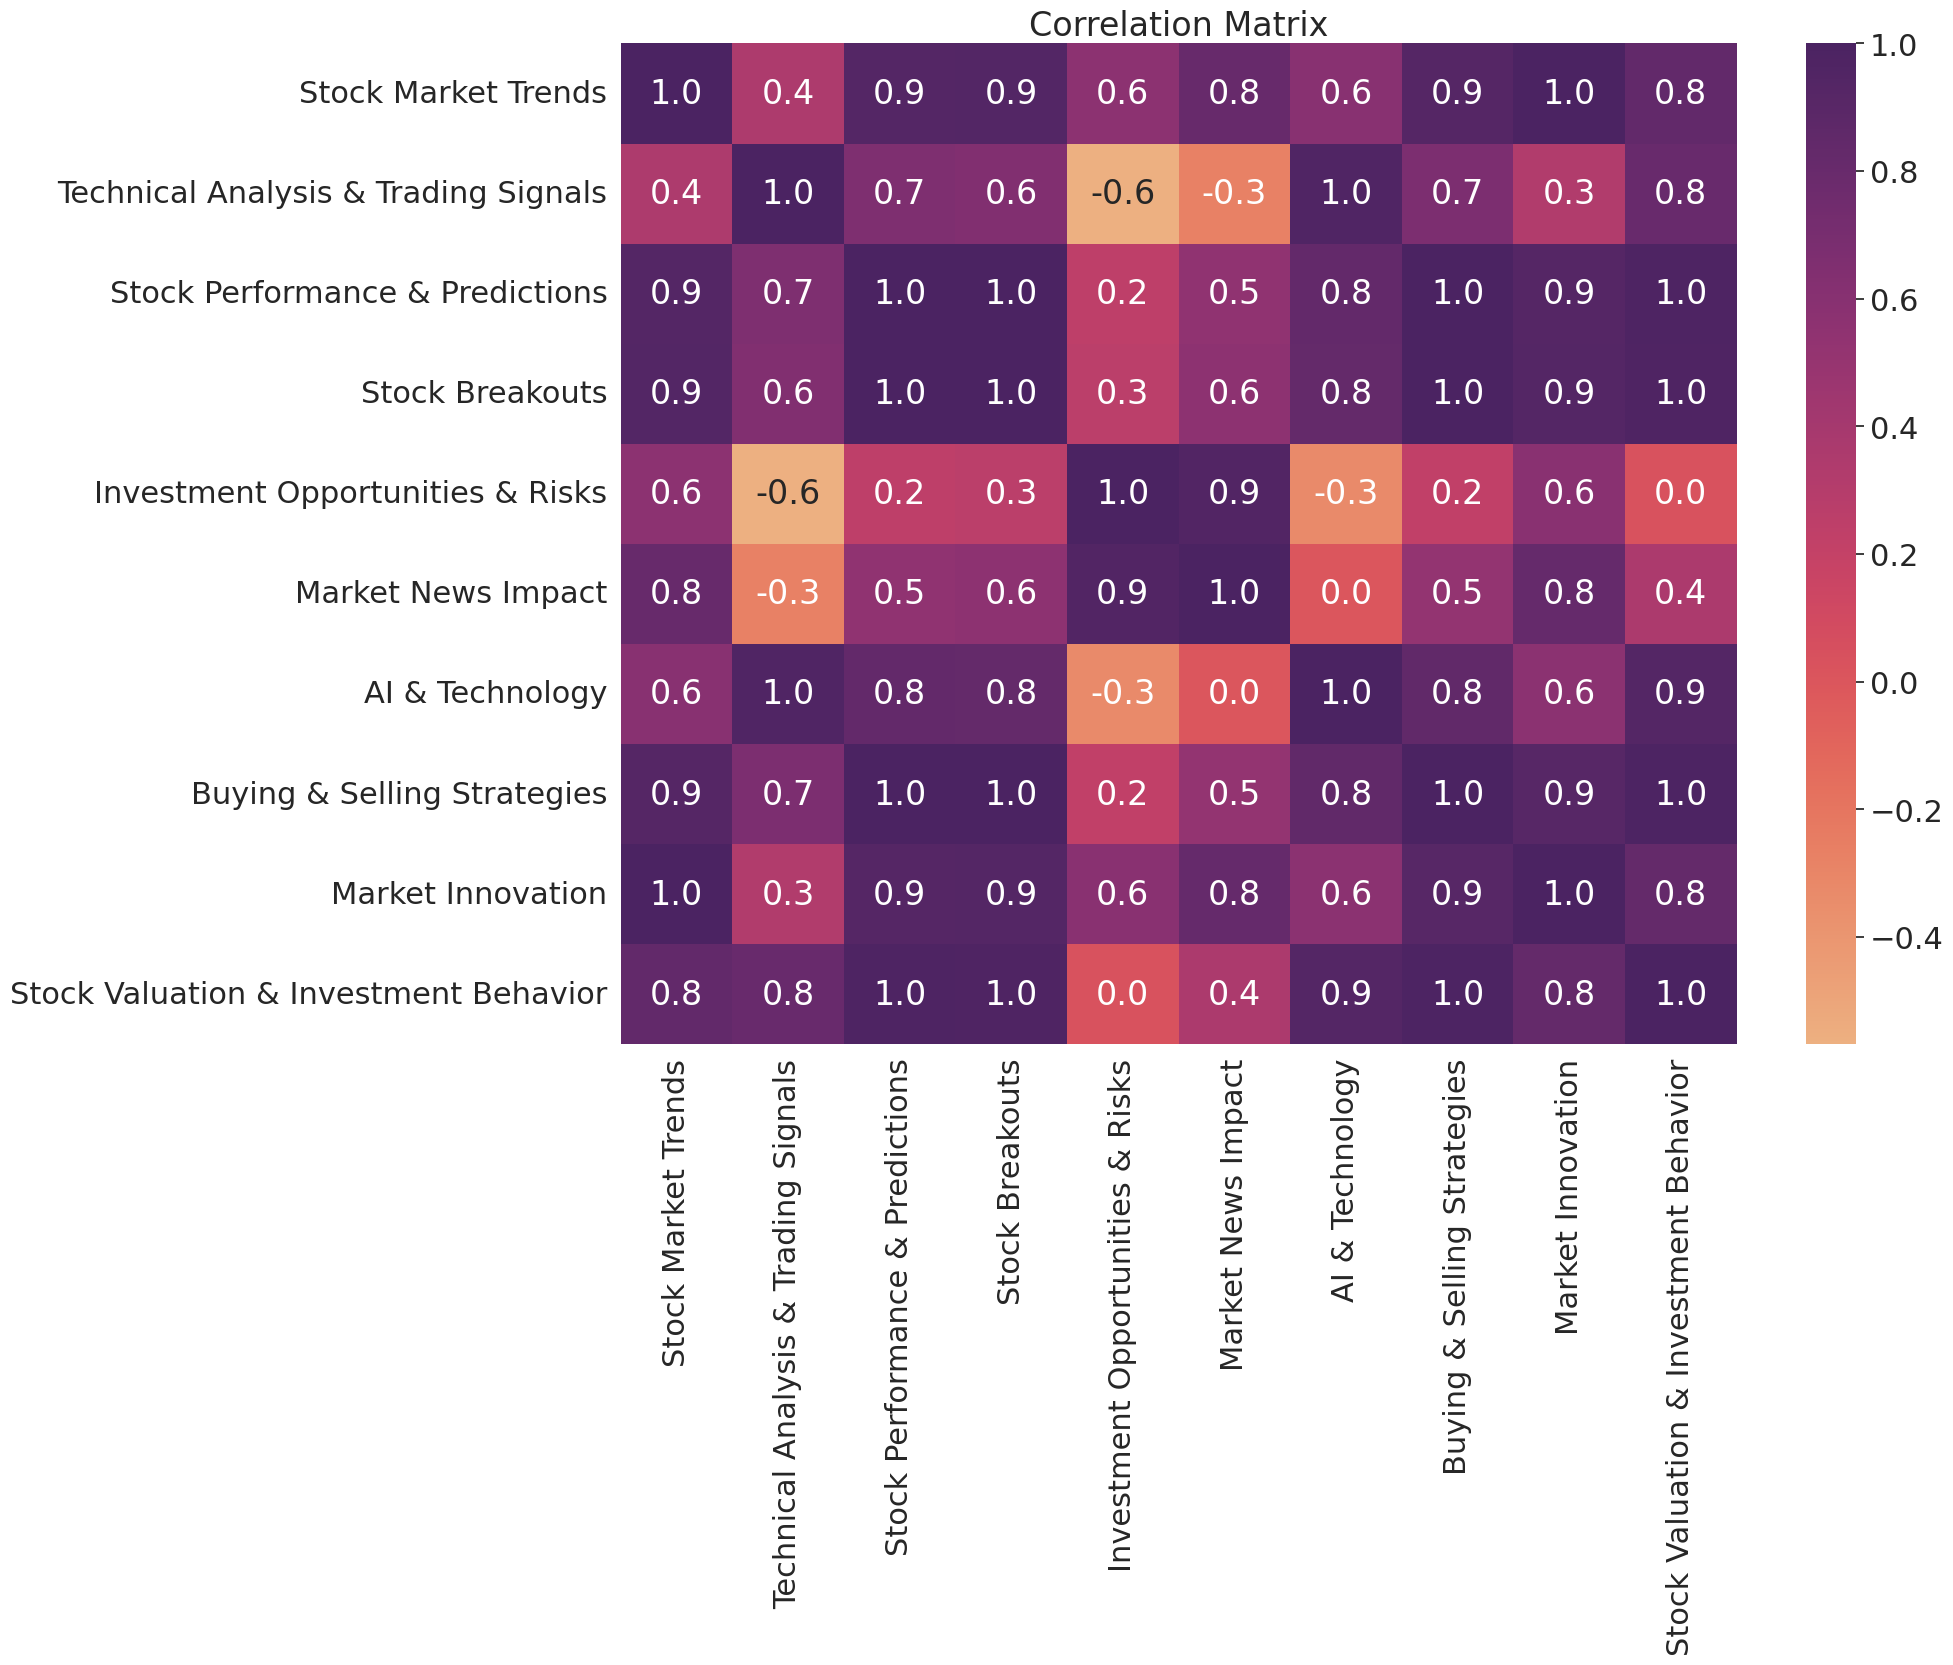

In [71]:
# Define the data
topic_names = [
    'Stock Market Trends',
    'Technical Analysis & Trading Signals',
    'Stock Performance & Predictions',
    'Stock Breakouts',
    'Investment Opportunities & Risks',
    'Market News Impact',
    'AI & Technology',
    'Buying & Selling Strategies',
    'Market Innovation',
    'Stock Valuation & Investment Behavior']

# Get the topic-polarity matrix
topic_polarity_matrix = df_topic_polarity.values

# Calculate the correlation matrix
correlation_matrix = np.corrcoef(topic_polarity_matrix)
fig, ax = plt.subplots(figsize=(18, 13))
sns.heatmap(correlation_matrix, annot=True, cmap="flare", fmt=".1f", xticklabels=topic_names, yticklabels=topic_names)
plt.title("Correlation Matrix")
plt.show()

###Plot dendongram chart for the topic identified

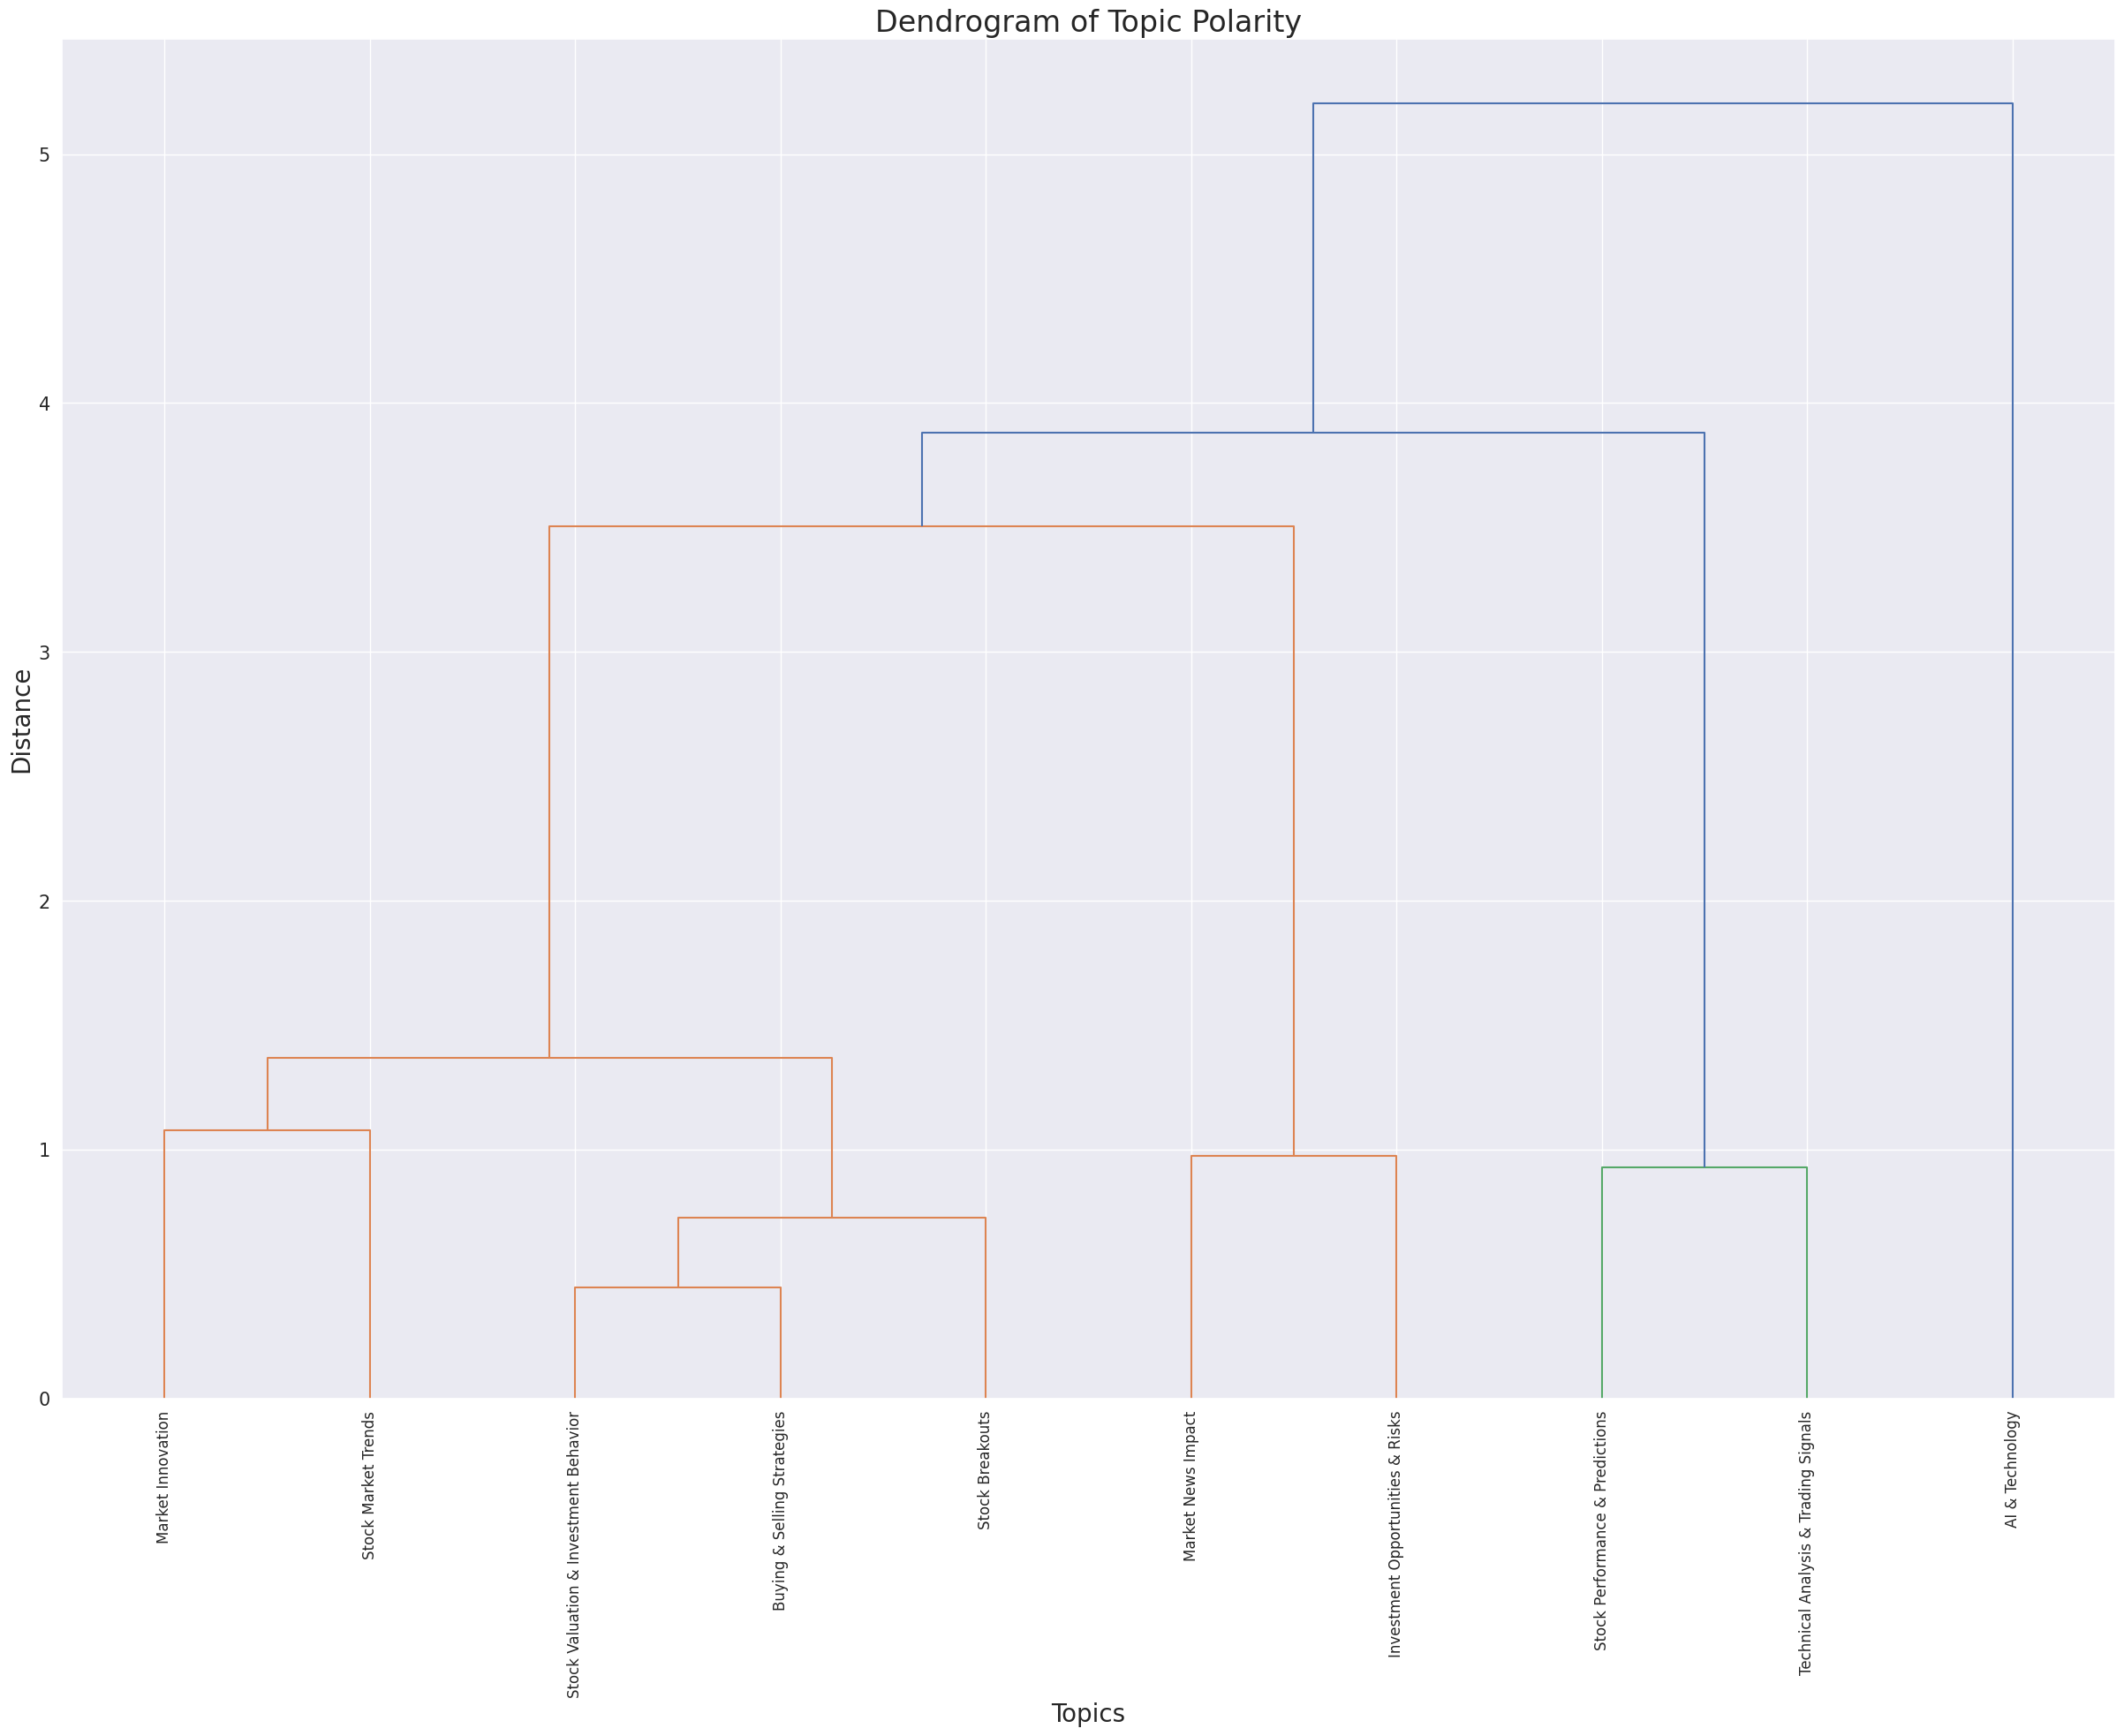

In [72]:

import scipy.cluster.hierarchy as sch
from sklearn.preprocessing import StandardScaler

# Standardize the topic-polarity matrix
scaler = StandardScaler()
scaled_topic_polarity_matrix = scaler.fit_transform(topic_polarity_matrix)

# Calculate the linkage
linkage_matrix = sch.linkage(scaled_topic_polarity_matrix, method='ward')

# Create the dendrogram
plt.figure(figsize=(30, 20))
sch.dendrogram(linkage_matrix, orientation='top', distance_sort='descending', labels=topic_names)
plt.title('Dendrogram of Topic Polarity', size=24)
plt.xlabel('Topics', size=20)
plt.ylabel('Distance', size=20)
plt.tick_params(axis='x', rotation=90)
plt.tick_params(axis='y', which='major', labelsize=15)
plt.show()


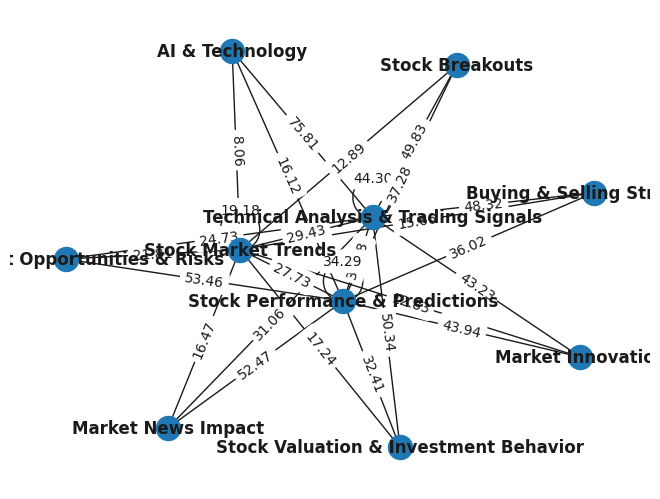

In [73]:
# Create a graph
G = nx.Graph()

# Add nodes to the graph
G.add_nodes_from(topic_names)

# Add edges to the graph based on the polarity matrix
for i in range(len(topic_polarity_matrix)):
    for j in range(len(topic_polarity_matrix[0])):
        if topic_polarity_matrix[i][j] > 0.5:
            G.add_edge(topic_names[i], topic_names[j], weight=topic_polarity_matrix[i][j])

# Set the layout of the nodes
pos = nx.spring_layout(G)

# Draw the graph
nx.draw(G, pos, with_labels=True, font_weight='bold')

# Set the edge labels
edge_labels = {(u, v): f'{d["weight"]:.2f}' for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

# Show the plot
plt.show()


###Load libraries for Network Analysis

###Check for the degree of centrality and betweenness for the topics identified

In [74]:
# Calculate degree centrality
degree_centrality = nx.degree_centrality(G)

# Calculate betweenness centrality
betweenness_centrality = nx.betweenness_centrality(G)

# Print the results
print("Degree Centrality:")
for node, centrality in degree_centrality.items():
    print(f"{node}: {centrality}")

print("\nBetweenness Centrality:")
for node, centrality in betweenness_centrality.items():
    print(f"{node}: {centrality}")


Degree Centrality:
Stock Market Trends: 1.222222222222222
Technical Analysis & Trading Signals: 1.222222222222222
Stock Performance & Predictions: 1.222222222222222
Stock Breakouts: 0.3333333333333333
Investment Opportunities & Risks: 0.3333333333333333
Market News Impact: 0.3333333333333333
AI & Technology: 0.3333333333333333
Buying & Selling Strategies: 0.3333333333333333
Market Innovation: 0.3333333333333333
Stock Valuation & Investment Behavior: 0.3333333333333333

Betweenness Centrality:
Stock Market Trends: 0.19444444444444442
Technical Analysis & Trading Signals: 0.19444444444444442
Stock Performance & Predictions: 0.19444444444444442
Stock Breakouts: 0.0
Investment Opportunities & Risks: 0.0
Market News Impact: 0.0
AI & Technology: 0.0
Buying & Selling Strategies: 0.0
Market Innovation: 0.0
Stock Valuation & Investment Behavior: 0.0


In [77]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import GradientBoostingClassifier

# Assuming 'Analysis_Polarity' is your target variable and other relevant features are in X
X = df[['Polarity', 'Subjectivity', 'Topic']]  # Example features, replace with your actual features
y = df['Analysis_Polarity']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define models
models = []
models.append(('LR', LogisticRegression(solver='lbfgs', multi_class='auto')))
models.append(('KNN', KNeighborsClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVC', SVC(gamma='scale')))
models.append(('RFC', RandomForestClassifier(n_estimators=100)))
models.append(('DTC', DecisionTreeClassifier()))
models.append(('GBC', GradientBoostingClassifier()))


# Evaluate models
results = []
names = []
for name, model in models:
    try:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        print(f"Model: {name}, Accuracy: {accuracy}")
        print(classification_report(y_test, y_pred))
        results.append(accuracy)
        names.append(name)
    except Exception as e:  # Handle potential errors during model training/prediction
        print(f"Error with model {name}: {e}")
        results.append(0)
        names.append(name)


Model: LR, Accuracy: 0.926829268292683
              precision    recall  f1-score   support

    Negative       1.00      0.86      0.92       141
     Neutral       0.90      0.94      0.92       392
    Positive       0.93      0.94      0.93       328

    accuracy                           0.93       861
   macro avg       0.94      0.91      0.93       861
weighted avg       0.93      0.93      0.93       861

Model: KNN, Accuracy: 0.9512195121951219
              precision    recall  f1-score   support

    Negative       0.93      0.91      0.92       141
     Neutral       0.94      0.96      0.95       392
    Positive       0.97      0.95      0.96       328

    accuracy                           0.95       861
   macro avg       0.95      0.94      0.95       861
weighted avg       0.95      0.95      0.95       861

Model: NB, Accuracy: 0.9732868757259001
              precision    recall  f1-score   support

    Negative       0.94      0.90      0.92       141
     Neut

In [78]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,ConfusionMatrixDisplay

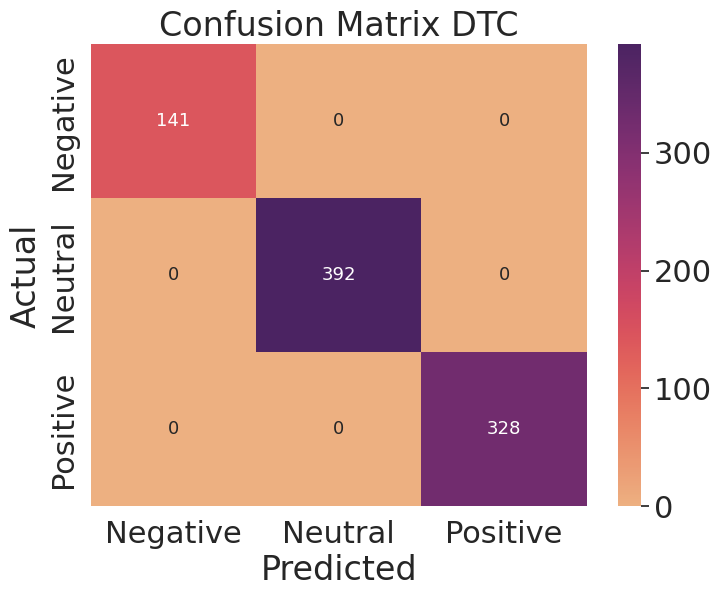

In [79]:
model = DecisionTreeClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="flare",
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'],
            annot_kws={"size": 13})
plt.title("Confusion Matrix DTC")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()